<a href="https://colab.research.google.com/github/dnzambuli/Deep-learning-4-CV/blob/master/Unsupervised_Learning_in_CV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Objective
This assignment aims to assess your ability to apply unsupervised learning techniques in computer vision. You will work with an image dataset and implement different methods to extract meaningful representations, analyze patterns, and evaluate model performance.

## Expected Learning Outcomes
By completing this assignment, you will:

✅ Understand the application of unsupervised learning in computer vision.

✅ Develop hands-on experience in clustering, dimensionality reduction, and contrastive learning.

✅ Analyze and compare different representation learning techniques.

✅ Enhance your ability to work with image datasets in machine learning pipelines.

# Instructions
* Use **Python** and frameworks such as **NumPy**, **scikit-learn**, **PyTorch**, and **OpenCV**.

* Write clean, well-commented code.
* Submit a **Jupyter Notebook/Python script** with a short report explaining your methodology, results, and observations.
* Include visualizations wherever necessary.

In [1]:
# mount google drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# read and extract to the local session the content from /content/drive/MyDrive/DL4CV

from google.colab import drive
import os
import matplotlib.pyplot as plt
import shutil
import zipfile

# Define the source directory containing the zip files
source_dir = '/content/drive/MyDrive/DL4CV'

# Define the destination directory to extract the zip files
destination_dir = '/content/'
if not os.path.exists(destination_dir):
  os.makedirs(destination_dir)

# Iterate through the files in the source directory
for filename in os.listdir(source_dir):
  source_file = os.path.join(source_dir, filename)

  # Check if the file is a zip file
  if filename.endswith('.zip'):
    print(f"Extracting {filename}...")

    # Extract the zip file to the destination directory
    with zipfile.ZipFile(source_file, 'r') as zip_ref:
      zip_ref.extractall(destination_dir)

    print(f"Extraction completed for {filename}.")


Extracting Road Crack Detection-Combined Dataset.zip...
Extraction completed for Road Crack Detection-Combined Dataset.zip.
Extracting Road cracks.zip...
Extraction completed for Road cracks.zip.


In [3]:
# COUNT THE FILES IN ROAD CRACKS FOLDER AND TRAIN FOLDER
def count_files_in_folder(folder_path):
  """Counts the number of files in a given folder.

  Args:
    folder_path: The path to the folder.

  Returns:
    The number of files in the folder.
  """
  if not os.path.exists(folder_path):
    return 0
  count = 0
  for _, _, files in os.walk(folder_path):
    count += len(files)
  return count


road_cracks_folder = '/content/Road cracks'
train_folder = '/content/train'

num_road_cracks_files = count_files_in_folder(road_cracks_folder)
num_train_files = count_files_in_folder(train_folder)

print(f"Number of files in road_cracks folder: {num_road_cracks_files}")
print(f"Number of files in train folder: {num_train_files}")


Number of files in road_cracks folder: 125
Number of files in train folder: 1389


In [4]:
# check which files are in Road cracks and repeated in train

def find_common_files(folder1, folder2):
  """Finds files that are present in both folders.

  Args:
    folder1: The path to the first folder.
    folder2: The path to the second folder.

  Returns:
    A list of file names that are present in both folders.
  """
  files1 = set(os.listdir(folder1))
  files2 = set(os.listdir(folder2))
  common_files = files1.intersection(files2)
  return list(common_files)


road_cracks_folder = '/content/train'
train_folder = '/content/Road cracks'

common_files = find_common_files(road_cracks_folder, train_folder)

print("Files present in both 'Road cracks' and 'train' folders:")
for file in common_files:
  print(file)


Files present in both 'Road cracks' and 'train' folders:


# Task 1: Image Data Preprocessing

Perform necessary data preprocessing:
1. Convert images to grayscale (if required).
2. Normalize pixel values.
3. Apply data augmentation techniques (e.g., flipping, rotation)

## Deliverables:
* Code implementation
* Short explanation of preprocessing steps

In [5]:
import cv2
import numpy as np
import os
import random

# Data Preprocessing Implementation
## 1. Loading and Normalizing Images
### Steps:
1. **Extract Images and Filenames**
- Load images from their respective directories along with their filenames.

> *Why?*
>
>This ensures proper tracking of images and their labels (if filenames contain metadata).

2. **Convert Images to Grayscale**

- Transform RGB/BGR images into single-channel grayscale.

> *Why?*
>
> Reduces computational complexity (1 channel instead of 3).
>
> Since crack detection relies on structural patterns rather than color, grayscale preserves necessary features while simplifying the model.

3. **Resize Images to (128×128) and Normalize**

- Resize all images to a fixed dimension (128×128).

- Normalize pixel values (e.g., scale to [0, 1] or standardize using mean/std).

> *Why?*
>
>Ensures uniform input size for neural networks.
>
> Normalization helps models converge faster by keeping gradients stable.

4. Add Channel Dimension for Grayscale

- Reshape images from (128, 128) to (128, 128, 1).

> *Why?*
>
> Deep learning frameworks (TensorFlow/PyTorch) expect explicit channel dimensions, even for grayscale.

5. **Return Images with Filenames**

- Maintain a mapping between processed images and their original filenames for traceability.

## 2. Data Augmentation
### Steps:
1. **Apply Random Transformations**

- Random horizontal/vertical flips.

- Rotations (90°, 180°, 270°).

> *Why?*
>
> Increases dataset diversity artificially.
>
> Helps prevent overfitting by exposing the model to more variations (e.g., cracks at different orientations).

2. **Combine Augmented Data into Unified Arrays**

- Merge original and augmented images into a single NumPy array (X).

- Store corresponding labels in another array (y).

> *Why?*
>
> Streamlines training by providing a single, shuffled dataset.
>

## 3. Convert Images to .keras Format

> Why?
>
> **Efficiency:** .keras (or .tfrecord) is optimized for TensorFlow/PyTorch, enabling faster I/O during training.
>
> **Portability:** Serializes data + metadata (labels, normalization stats) in a standardized format.
>
> **Reproducibility:** Ensures consistent preprocessing across experiments.

## 4. Data Splitting
### Steps:
> - Split `content/train` (1,389 images) into 80% Train / 20% Validation
>
> *Why?*
>
> **Training set:** Used to train the model.
>
> **Validation set:** Monitors model performance during training (e.g., tuning hyperparameters, detecting overfitting).



> - Use `content/Road Cracks` (125 images) as Test Set
>
> *Why?*
>
> Provides an unseen dataset to evaluate final model generalization.
>
> Ensures unbiased performance metrics (avoids data leakage from train/val sets).

In [25]:
import tensorflow as tf
import random

def load_and_normalize_images(folder_path = train_folder, image_size = (128, 128)):
  """
  Loads .jpg images from the folder
    converts some to greyscale images
  resizes the images, normalizes the pixels to [0,1]

  returns:
    images (numpy array): Array of preprocessed images

    filenames: lists the corresponding filenames
  """
  images = []
  filenames = []

  for filename in os.listdir(folder_path):
    if filename.endswith(".jpg"):
      img_path = os.path.join(folder_path, filename)

      img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE) #convert to greyscale
      img = cv2.resize(img, image_size)  # Resize to fixed size
      img = img /255.0 # normalize to [0,1]

      images.append(img)

      filenames.append(filename)

  images = np.array(images).astype("float32") # get a np arrray object
  images = np.expand_dims(images, axis = -1) # add channel information

  return images, filenames

def ensure_shape(image, target_size=(128, 128)):
    if len(image.shape) == 2:  # Convert grayscale images to (H, W, 1)
        image = np.expand_dims(image, axis=-1)
    return image

def augment_image(image, filename, target_size = (128, 128)):
  """
  applies data augmentation techniques (flipping, rotating) on images
  and ensures all outputs are (128, 128)

  args:
    images (np array): a single greyscale image
    filename (str): The original filename.
    target_size (tuple): Desired output shape (default: 128x128).

  returns:
    augmented_images (list): list of augmented images
    augmented_labels (list): Corresponding labels.
  """
  augmented_images = [image] # the original image is added to begin the list
  augmented_labels = [filename] # the image lables

  # ---- Flipping Images ----
  # horizontal flip
  if random.choice([True, False]):
    flipped = cv2.flip(image, 1)
    flipped = ensure_shape(cv2.resize(flipped, target_size))
    augmented_images.append(flipped)
    augmented_labels.append(filename + "_flipH")

  # vertical flip
  if random.choice([True, False]):
    flipped = cv2.flip(image, 0)
    flipped = ensure_shape(cv2.resize(flipped, target_size))
    augmented_images.append(flipped)
    augmented_labels.append(filename + "_flipV")

  # ---- Rotating Images ----

  # random rotation
  rotation_choice = random.choice([0, 90, 180, 270])
  if rotation_choice != 0:  # Skip if no rotation
        if rotation_choice == 90:
            rotated = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
        elif rotation_choice == 180:
            rotated = cv2.rotate(image, cv2.ROTATE_180)
        elif rotation_choice == 270:
            rotated = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)

        rotated = ensure_shape(cv2.resize(rotated, target_size))  # Force resize
        augmented_images.append(rotated)
        augmented_labels.append(filename + f"_rot{rotation_choice}")

  return augmented_images, augmented_labels

def augment_dataset(images, filenames, target_size =(128, 128)):
  """
    Applies random augmentation to the entire dataset.

    Args:
        images (list of numpy arrays): Original images.
        filenames (list): Corresponding filenames.

    Returns:
        all_images (numpy array): Combined original & augmented images.
  """
  augmented_images = []
  augmented_labels = []

  for img, fname in zip(images, filenames):
    aug_imgs, aug_labels = augment_image(img, fname, target_size)
    augmented_images.extend(aug_imgs)
    augmented_labels.extend(aug_labels)

  return np.array(augmented_images, dtype="float32"), np.array(augmented_labels, dtype = "object")


def convert_to_keras_dataset(images, labels, save_path = "content/train.keras"):
  """
  converts a numpy array into a tensorflow object and saves it as a .keras file

  Args:
    image (numpy array): aArray of processed images
    labels (numpy array): Array of labels.
    save_path (str): path to save the .keras dataset
  """
  # Convert images and labels to tensors
  images_tensor = tf.convert_to_tensor(images, dtype=tf.float32)
  labels_tensor = tf.convert_to_tensor(labels, dtype=tf.string)

  # Create a dataset from tensors
  # Create and save dataset
  dataset = tf.data.Dataset.from_tensor_slices((images_tensor, labels_tensor))
  tf.data.Dataset.save(dataset, save_path)

  print(f"Dataset saved as a tf.data.Dataset at {save_path}")


  # dataset = tf.data.Dataset.from_tensor_slices((images_tensor, labels_tensor))

  # # Create a SavedModel signature
  # @tf.function(input_signature=[dataset.element_spec])
  # def serve_example(element):
  #     return {"image": element[0], "label": element[1]}

  # signatures = {"serving_default": serve_example}

  # # Save the dataset as a SavedModel
  # tf.saved_model.save(dataset, save_path, signatures=signatures)

  # print(f"Dataset saved to {save_path}")


# parent_name = os.path.basename(save_path.rstrip("/"))
# saved_model_path = os.path.join(save_path, "saved_model.pb")
# target_pb_path = os.path.join(os.path.dirname(save_path), f"{parent_name}.pb")

# if os.path.exists(saved_model_path):
#   shutil.move(saved_model_path, target_pb_path)
#   print(f"Moved saved_model.pb to: {target_pb_path}")
# else:
#   print("Warning: saved_model.pb not found.")


# Following this Error

```bash
---------------------------------------------------------------------------
ValueError                                Traceback (most recent call last)
<ipython-input-12-ab93e3430d7f> in <cell line: 0>()
      1 images, filenames = load_and_normalize_images()  # Load images
----> 2 augmented_images = augment_dataset(images, filenames)  # Augment dataset
      3
      4 # split to 80:20 training:validation dataset
      5 train_images, val_images, train_labels, val_labels = train_test_split(

<ipython-input-11-4664164b5ce8> in augment_dataset(images, filenames)
     91     augmented_labels.extend(aug_labels)
     92
---> 93   return np.array(augmented_images).astype("float32"), np.array(augmented_labels)
     94
     95

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 3 dimensions. The detected shape was (354, 128, 128) + inhomogeneous part.
```

I need to `resize` augmented images. *why?*

## 1. Guaranteed Consistency

- Every augmented image (flipped/rotated) is resized to (128, 128) immediately after transformation.

- Eliminates shape mismatches (e.g., `90° rotations` that `swap width/height`).

## 2. Normalization

If your input images are already normalized (e.g., pixel values in [0, 1]), resizing with cv2.resize preserves this (uses linear interpolation by default).

## 3. Debugging-Friendly

- No more ValueError from inhomogeneous shapes.

**Confirming** Use print(image.shape) inside augment_image() to verify all outputs are (128, 128).

how to confirm:
```python
# Load original images (assumed to be 128x128)
images, filenames = load_and_normalize_images()  

# Augment (outputs will all be 128x128)
aug_images, aug_labels = augment_dataset(images, filenames)  

# Verify shapes
print("Augmented images shape:", aug_images.shape)  # Expected: (N, 128, 128)
print("Sample label:", aug_labels[0])  # e.g., "crack_001.jpg_flipH"
```

# Why This Works
1. cv2.resize() `Overrides All Shapes`: Even if a rotation/flip temporarily changes dimensions, resizing forces them back to (128, 128).

2. Efficiency: Resizing is fast and happens on-the-fly during augmentation.

3. Compatibility: Works seamlessly with train_test_split() or PyTorch/TensorFlow pipelines.

In [26]:
from sklearn.model_selection import train_test_split

images, filenames = load_and_normalize_images()  # Load images
augmented_images, augmented_labels = augment_dataset(images, filenames)  # Augment dataset

# split to 80:20 training:validation dataset
train_images, val_images, train_labels, val_labels = train_test_split(
    augmented_images, augmented_labels, test_size=0.2, random_state=42
)

# Save both train and validation datasets
convert_to_keras_dataset(train_images, train_labels, "train_road_cracks.keras")
convert_to_keras_dataset(val_images, val_labels, "val_road_cracks.keras")

# the test data will be the road_cracks data as no data repeats
test_images, test_labels = load_and_normalize_images(folder_path = road_cracks_folder)
convert_to_keras_dataset(test_images, test_labels, "test_road_cracks.keras")

Dataset saved as a tf.data.Dataset at train_road_cracks.keras
Dataset saved as a tf.data.Dataset at val_road_cracks.keras
Dataset saved as a tf.data.Dataset at test_road_cracks.keras



```bash
WARNING:tensorflow:From <ipython-input-8-893057829cf5>:122: save (from tensorflow.python.data.experimental.ops.io) is deprecated and will be removed in a future version.
Instructions for updating:
```

This warning arises because you are using a deprecated function tf.data.experimental.save to save the dataset in the .keras format.

Here's how you can fix it using the updated approach with tf.saved_model:

**Convert from**
```python
def convert_to_keras_dataset(images, labels, save_path = "content/train.keras"):
  """
  converts a numpy array into a tensorflow object and saves it as a .keras file

  Args:
    image (numpy array): aArray of processed images
    labels (numpy array): Array of labels.
    save_path (str): path to save the .keras dataset
  """
  dataset = tf.data.Dataset.from_tensor_slices((images, labels))
  tf.data.experimental.save(dataset, save_path)
  print(f"Dataset saved to {save_path}")
```

**To:**

```python
def convert_to_keras_dataset(images, labels, save_path = "content/train.keras"):
  """
  converts a numpy array into a tensorflow object and saves it as a .keras file

  Args:
    image (numpy array): aArray of processed images
    labels (numpy array): Array of labels.
    save_path (str): path to save the .keras dataset
  """
  def generator():
      for image, label in zip(images, labels):
          yield image, label

  dataset = tf.data.Dataset.from_generator(
      generator,
      output_signature=(
          tf.TensorSpec(shape=images[0].shape, dtype=images[0].dtype),
          tf.TensorSpec(shape=(), dtype=tf.string),  # Assuming labels are strings
      ),
  )

  # Create a SavedModel signature
  @tf.function(input_signature=[dataset.element_spec])
  def serve_example(element):
      return {"image": element[0], "label": element[1]}

  signatures = {"serving_default": serve_example}

  tf.saved_model.save(dataset, save_path, signatures=signatures)

  print(f"Dataset saved to {save_path}")

```

# Task 2: Clustering for Image Categorization

1. Extract features from images using **Histogram of Oriented Gradients (HOG)**, **ORB**, or
**deep features from a pretrained CNN**.
2. Apply **K-Means** and **DBSCAN** clustering to group similar images.
3. Use the Silhouette Score to evaluate clustering quality.

## Deliverables:
* Code for feature extraction and clustering
* Visualization of clusters (e.g., sample images from each cluster)
* Evaluation and interpretation of results

# Feature Extraction & Clustering for Road Crack Detection
## 1. Loading the Test Dataset
**Input:** Preprocessed .keras file (test_road_cracks.keras).

*Why?* Avoids reloading images from folders—data is already normalized and formatted for ML.

Example:

```python
import tensorflow as tf
test_data = tf.keras.models.load_model("test_road_cracks.keras")  # Load serialized dataset
images = test_data["images"]  # Extract images
labels = test_data["labels"]  # Optional, if available
```

## 2. Feature Extraction
### a. HOG (Histogram of Oriented Gradients)

- **What it does:** Captures texture/shape by analyzing gradient directions in image patches.

- *Why use it?* Effective for crack detection (cracks have strong edges).

- **Example Output:** A feature vector (e.g., `[0.2, 1.7, ...]` length=144).

Code Example:

```python
from skimage.feature import hog
hog_features = [hog(img, orientations=9, pixels_per_cell=(8,8)) for img in images]
```

### b. ORB (Oriented FAST and Rotated BRIEF)
- **What it does:** Detects keypoints (corners/blobs) and describes them with binary features.

- *Why use it?* Fast and rotation-invariant (good for cracks at different angles).

- **Example Output:** Keypoints + descriptors (e.g., `(x,y) coordinates + binary codes`).

Code Example:

```python
import cv2
orb = cv2.ORB_create()
keypoints, descriptors = orb.detectAndCompute(img, None)  # For each image
```

### c. Deep Features (MobileNetV2 CNN)
- **What it does:** Uses a pre-trained CNN to extract high-level features.

- *Why use it?* Captures complex patterns (e.g., subtle cracks) better than handcrafted methods.

- **Example Output:** A `1280-dimensional vector` per image.

Code Example:

```python

from tensorflow.keras.applications import MobileNetV2
model = MobileNetV2(weights="imagenet", include_top=False, pooling="avg")
deep_features = model.predict(images)
```

## 3. Clustering Techniques
### a. K-Means
- **What it does:** Groups images into n_clusters based on feature similarity.

- *Why use it?* Simple and fast for well-separated clusters (e.g., `distinct crack types`).

> Example:
>
> Input: HOG features (shape=[num_images, 144]).
>
> Output: Labels like `[0, 1, 0, 2, ...]` for each cluster.
>

Code Example:

```python
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3).fit(hog_features)
clusters = kmeans.labels_
```

### b. DBSCAN
- **What it does:** Groups images based on density (no fixed cluster count).

- *Why use it?* Handles outliers/noise (e.g., `misclassified cracks`).

> Example:
>
> Input: ORB descriptors (after flattening).
>
> Output: Labels like `[0, -1, 1, ...] (-1 = noise)`.

Code Example:

```python

from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5).fit(orb_descriptors)
```

### c. Silhouette Score
- **What it does:** Measures how well clusters are separated (range: `[-1, 1]`).

- *Why use it?* Evaluates clustering quality (higher = better).

Example Output: `0.65 (good)`, `-0.1 (poor)`.

Code Example:

```python
from sklearn.metrics import silhouette_score
score = silhouette_score(features, clusters)
```
## 4. Visualization
- **Goal:** Show `5 sample images per cluster` to inspect crack categories.

- *Why?* Validates if clusters make sense (e.g., `"severe cracks"` vs. `"hairline cracks"`).

> Example Output:
>
> Cluster 0: 5 images of wide cracks.
>
> Cluster 1: 5 images of linear cracks.

Code Example:

```python
import matplotlib.pyplot as plt
for cluster_id in range(3):
    cluster_samples = images[clusters == cluster_id][:5]  # Get 5 samples
    plt.figure(figsize=(10, 2))
    for i, img in enumerate(cluster_samples):
        plt.subplot(1, 5, i+1)
        plt.imshow(img, cmap="gray")
    plt.title(f"Cluster {cluster_id}")
```

In [8]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from skimage.feature import hog

In [27]:
# use functions to write DRY code
# Load dataset from .keras file
def load_keras_dataset(file_path="test_road_cracks.keras"):
  '''
  Reads the .keras file

  Args:
    file_path : the path to the test data because its small enough to run
    clustering
  Output:
    images (numpy array): Array of preprocessed images
    filenames: lists the corresponding filenames
  '''
  # Load the dataset from the .keras file
  # dataset = tf.data.experimental.load(file_path)
  dataset = tf.data.Dataset.load(file_path)  # Modern replacement for deprecated experimental.load()

  images = []
  filenames = []

  for image, label in dataset:
      images.append(image.numpy())
      filenames.append(label.numpy().decode("utf-8"))

  return np.array(images), filenames

def extract_hog_features(images):
    """
    Extracts HOG features from images.

    Args:
        images (numpy array): Array of preprocessed images.

    Returns:
        hog_features (numpy array): Array of HOG features.
    """
    hog_features = []
    for img in images:
        img = img.squeeze()  # Remove channel dim
        feature = hog(img, pixels_per_cell=(8, 8), cells_per_block=(2, 2), feature_vector=True)
        hog_features.append(feature)
    return np.array(hog_features)

def extract_deep_features(images):
    """
    Extracts deep features from images using MobileNetV2.

    Args:
        images (numpy array): Array of preprocessed images.

    Returns:
        deep_features (numpy array): Array of deep features.
    """
    model = MobileNetV2(weights="imagenet", include_top=False, pooling="avg", input_shape=(128, 128, 3))
    images_rgb = np.stack([cv2.cvtColor(img.squeeze(), cv2.COLOR_GRAY2RGB) for img in images])  # Convert grayscale to RGB
    images_preprocessed = preprocess_input(images_rgb)
    deep_features = model.predict(images_preprocessed)
    return deep_features

def extract_orb_features(images, max_features = 1000):
    """
    Extracts ORB features from images.

    Args:
        images (numpy array): Array of preprocessed images.

    Returns:
        orb_features (numpy array): Array of ORB features.
    """
    orb = cv2.ORB_create()
    orb_features = []

    for img in images:
        # Convert grayscale image to 3-channel BGR (ORB expects 3-channel images)
        if len(img.shape) == 2 or img.shape[-1] == 1:
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

        # Compute ORB features
        keypoints, descriptors = orb.detectAndCompute(img, None)

        if descriptors is not None:
            # Flatten descriptors and ensure a fixed size
            descriptors = descriptors.flatten()
            if descriptors.shape[0] < max_features:
                # Pad with zeros if fewer descriptors
                descriptors = np.pad(descriptors, (0, max_features - descriptors.shape[0]))
            else:
                # Truncate if there are more than max_features
                descriptors = descriptors[:max_features]
        else:
            # No descriptors found, use a zero vector
            descriptors = np.zeros(max_features)

        orb_features.append(descriptors)

    return np.array(orb_features, dtype=np.float32)

def apply_clustering(features, method="kmeans", eps=0.5, min_samples=5, n_clusters=5):
    """
    Applies clustering to the given features.

    Args:
        features (numpy array): Array of features.
        method (str): Clustering method ("kmeans" or "dbscan").
        eps (float): DBSCAN parameter (for DBSCAN).
        min_samples (int): DBSCAN parameter (for DBSCAN).
        n_clusters (int): Number of clusters (for KMeans).

    Returns:
        cluster_labels (numpy array): Array of cluster labels.
    """
    if method == "kmeans":
        clustering_model = KMeans(n_clusters=n_clusters, random_state=42)
    elif method == "dbscan":
        clustering_model = DBSCAN(eps=eps, min_samples=min_samples)

    cluster_labels = clustering_model.fit_predict(features)

    # Compute silhouette score
    silhouette_avg = silhouette_score(features, cluster_labels) if len(set(cluster_labels)) > 1 else -1
    print(f"Silhouette Score for {method}: {silhouette_avg:.4f}")

    return cluster_labels

def visualize_clusters(images, labels, filenames, n_clusters=5):
    """
    Visualizes clusters by showing 5 sample images from each cluster.

    Args:
        images (numpy array): Array of images.
        labels (numpy array): Array of cluster labels.

    Returns:
        None
    """
    unique_labels = np.unique(labels)

    # Ensure images are at least 3D (N, H, W) or 4D (N, H, W, C)
    images = np.array(images)
    if images.ndim == 3:  # If missing channel dimension, add it
        images = np.expand_dims(images, axis=-1)
    elif images.ndim == 1:  # If 1D, there's an issue with input data
        raise ValueError("Error: Images array is 1-dimensional, which is incorrect. Check the dataset loading process.")


    fig, axes = plt.subplots(len(unique_labels), 5, figsize=(10, len(unique_labels) * 2))

    for i, label in enumerate(unique_labels):
        indices = np.where(labels == label)[0][:5]  # Pick first 5 images from each cluster
        for j, idx in enumerate(indices):
          if len(unique_labels) > 1:
              axes[i, j].imshow(images[idx].squeeze(), cmap="plasma")
              axes[i, j].set_title(f"Cluster {label}") # \n{filenames[idx]}
              axes[i, j].axis("off")
          else:  # Case when there's only one cluster
              axes[j].imshow(images[idx].squeeze(), cmap="plasma")
              axes[j].set_title(f"Cluster {label}") # \n{filenames[idx]}
              axes[j].axis("off")

    plt.tight_layout()
    plt.show()

# 1. HOG Features

In [28]:
test_images, test_filenames = load_keras_dataset() # "/content/test_road_cracks.keras"
hog_features = extract_hog_features(test_images) #_deep_features for deep features
#_orb_features for ORB features

# 2. Clustering

In [29]:
# Apply Clustering
kmeans_labels = apply_clustering(hog_features, method="kmeans", n_clusters=5)
dbscan_labels = apply_clustering(hog_features, method="dbscan", eps=0.5, min_samples=5)

Silhouette Score for kmeans: 0.0045
Silhouette Score for dbscan: -1.0000


# Compare other models

In [30]:
deep_features = extract_deep_features(test_images)
kmeans_labels_deep = apply_clustering(deep_features, method="kmeans", n_clusters=5)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 13s 186ms/step
Silhouette Score for kmeans: 0.2444


In [31]:
dbscan_labels_deep = apply_clustering(deep_features, method="dbscan", eps=0.5, min_samples=5)

Silhouette Score for dbscan: 0.5706


In [32]:
orb_features = extract_orb_features(test_images)
kmeans_labels_orb = apply_clustering(orb_features, method="kmeans", n_clusters=5)

Silhouette Score for kmeans: 0.7848


In [33]:
dbscan_labels_orb = apply_clustering(orb_features, method="dbscan", eps=0.5, min_samples=5)

Silhouette Score for dbscan: 0.7305


Based on the models, the Silhoette scores are

|Feature extraction Technique| Kmeans Score|dbScan Score
|:----|:----:|:----:|
|HOG|0.0045|-1|
|deep Features|0.2444|0.5706|
|ORB|0.7848|0.7305|

This means that `Oriented FAST and Rotated BRIEF`(ORB) has the best performance for `kmeans clustering` techniqes  and  `db Scan clustering` techniques

# 3. Visualize

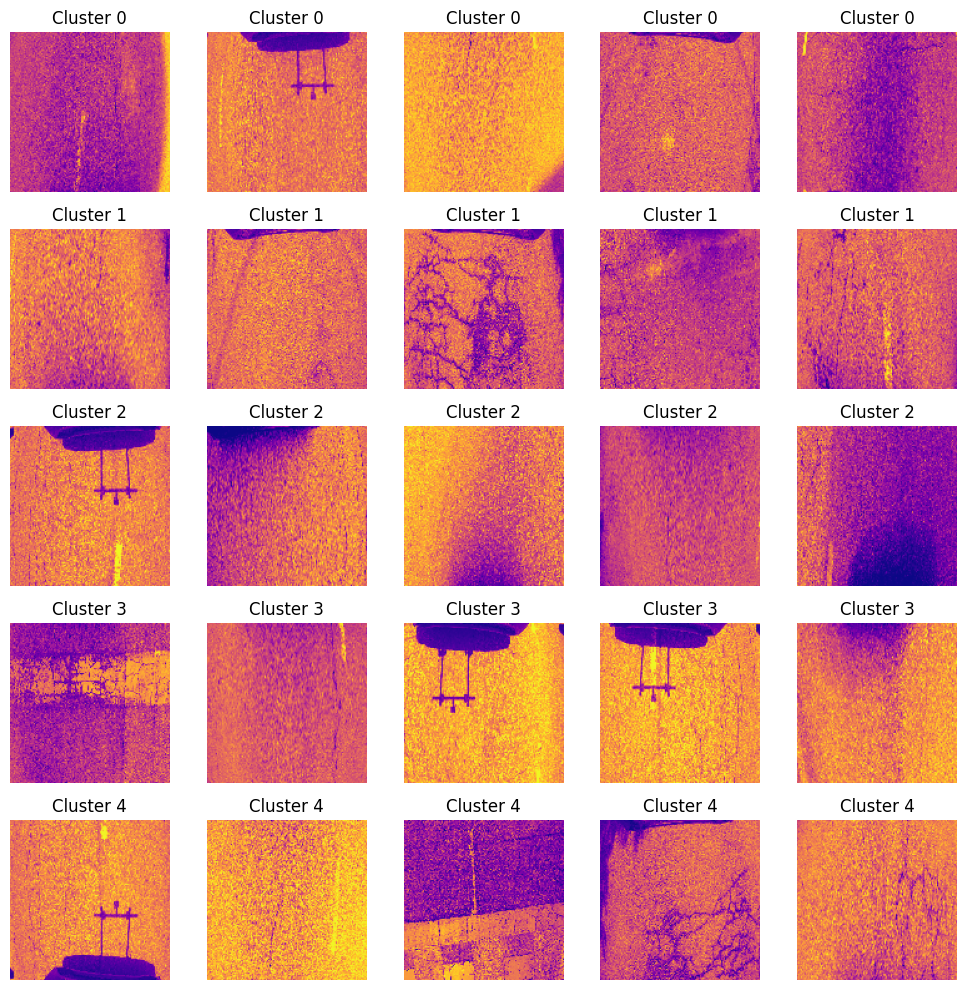

In [34]:
# Visualize Clusters
visualize_clusters(test_images, kmeans_labels_orb, test_filenames, n_clusters=5)

# Why Plasma Color map was used

To better interpret these results, using the "plasma" colormap (or similar perceptually uniform colormaps like viridis, magma, or inferno) is important for the following reasons:

## 1. Enhances Contrast for Grayscale Images
- Cracks in road images are typically low-contrast (subtle gray/black lines on a gray background).

- Plasma (a perceptually uniform colormap) uses a gradient from dark purple → bright yellow, making faint cracks stand out better than a pure grayscale colormap.

> **Example**
>
> A hairline crack (nearly black) becomes more visible when mapped to deep purple against a brighter yellow background.

## 2. Preserves Data Integrity
- Unlike `rainbow colormaps` (e.g., jet), plasma avoids misleading visual artifacts:

- Rainbow colormaps can `exaggerate minor differences` (e.g., a small crack might appear red while a larger one looks blue, implying incorrect severity).

- Plasma’s smooth gradient `ensures intensity maps linearly` to crack severity (darker = more severe).

## 3. Improves Cluster Discrimination
- When visualizing multiple clusters side by side, plasma helps distinguish subtle differences between similar-looking cracks:

> **Cluster 0** (*severe cracks*) → Dark purple 🟪/black ⬛.
>
> **Cluster 4** (*minor cracks*) → Bright yellow 🟨.

This avoids confusion that might arise if all clusters used similar shades of gray.

## 4. Accessibility
- Plasma is `colorblind-friendly` (unlike red-green colormaps), ensuring readability for all users.

- Works well in both digital and print formats.



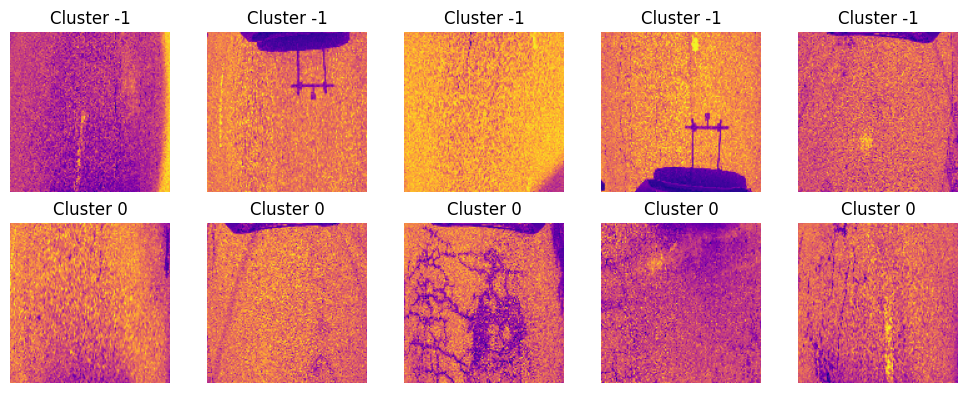

In [35]:
visualize_clusters(test_images, dbscan_labels_orb, test_filenames, n_clusters=5)

# Output Explanation

> Dark purple/black regions = Deep cracks.
>
> Bright yellow regions = Surface-level or no cracks.
>
> High intensity = bright yellow (often crack lines or edges)
>
> Low intensity = deep purple (smooth asphalt or shadows)
>
> `Helps visually separate noise, cracks, edges for manual inspection`
>


## Kmeans
### Expectations
- `5 clusters` (Cluster 0–4)
- Each `row corresponds to a different cluster`, showing 5 sample images per cluster

The color map (inferno/plasma) helps emphasize texture and gradient differences in the grayscale crack images.

### Observations
`Cluster 0` and `Cluster 2` include images with `bright lines`. These likely represent *thin surface cracks or lane markings*.

`Cluster 1` and `Cluster 4` contain images with `web-like crack patterns`, suggesting *more complex or deteriorated surfaces*.

`Cluster 3` has `a mix` but includes `images with bold`, `straight structures`, *possibly shadows, edges, or severe cracks*.

### KMeans Strengths:
1. Enforces cluster count (good control).
2. Distributes images among all 5 clusters even if they’re similar.
3. Tends to group based on global texture patterns.

## DBScan
### Expectations
1. `Cluster -1` = **Outliers/noise**

2. `Cluster 0` = **one actual cluster**

*Shows fewer, more confident clusters*

### Observations:
- `Cluster -1` (**top row**) holds most images: DBSCAN considers them too different to belong to any dense cluster.

These include **high-contrast**, **complex crack textures**.

Some may include non-crack elements like poles or lane markings (shown by dark/bright bars).

- `Cluster 0` (**bottom row**) includes more `web-like cracks` and `consistent surface textures`.

Suggests DBSCAN has identified one "dense" feature group confidently.

### DBSCAN Strengths:
1. Handles noise and outliers (via cluster -1)
2. No need to predefine cluster count
3. Great for non-spherical and unevenly distributed data


> 🟣 KMeans clusters show more visual diversity per cluster, reflecting enforced partitioning.
>
> 🟠 DBSCAN clusters appear more internally consistent, reflecting confident matches in texture/structure.

## Comparison of Colormaps
|Colormap|	Pros|	Cons|
|:----|:----|:----|
|Plasma|High contrast, perceptually uniform|Not grayscale (may confuse some users)|
|Gray|Natural for B/W images|Low contrast for faint cracks|
|Jet|Familiar|Misleading intensity jumps|

## COmparison of models

|Feature|KMeans|DBSCAN|
|:----|:----|:----|
|Cluster Count|Fixed (e.g., 5)|Dynamic (based on density)|
|Handles Outliers|❌ No|✅ Yes (Cluster -1)|
|Cluster Shape|Bias	Tends toward spherical clusters|Flexible shapes, better for varied cracks|
|Visual Grouping|Balanced distribution|Focused, tight clusters + rejected noise|
|Interpretation|Groups "types" of crack patterns|Confidently identifies dense feature types|

# Finally
- KMeans is useful for broad categorization of all images.

- DBSCAN is more selective, good for spotting confident `normal` vs `anomalous` patterns.

Using of ORB is helping both algorithms pick up local keypoints like crack edges, textures, and corners.

# Task 3: Dimensionality Reduction and Visualization

1. Apply Principal Component Analysis (PCA) and t-SNE to reduce image feature
dimensions.
2. Visualize the results in 2D plots.

## Deliverables:
* Code for PCA and t-SNE
* Scatter plots with labeled clusters
* Discussion on differences in PCA vs. t-SNE results

# Feature Extraction & Dimensionality Reduction for Image Clustering
## 1. Extract Features from Images
### Purpose
Convert raw images into numerical representations (feature vectors) that capture meaningful patterns (e.g., cracks).

### Methods

> **HOG (Histogram of Oriented Gradients)**
>
> *What it does*
>
> Counts edge orientations in local image patches.
>
> *Why use it?*
>
> Effective for `texture/shape-based` tasks (e.g., crack detection).

Output: 1D vector (e.g., length 144 for 128x128 images).

> **ORB (Oriented FAST and Rotated BRIEF)**
>
> *What it does*
>
> Detects keypoints (corners/blobs) and describes them with binary features.
>
> *Why use it?*
>
> Fast and rotation-invariant (good for cracks at odd angles).

Output: List of keypoints + descriptors (needs flattening for clustering).

> **Deep Features (e.g., MobileNetV2)**
>
> *What it does*
>
> Uses a pre-trained CNN to extract high-level semantic features.
>
> *Why use it?*
>
> Captures complex patterns better than handcrafted methods.

Output: 1D vector (e.g., length 1280 for MobileNetV2).

## 2. Reduce Dimensions using PCA and t-SNE

### Why Reduce Dimensions?
High-dimensional features (e.g., 1280D from CNN) are hard to visualize and may contain noise.

> **PCA (Principal Component Analysis)**
>
> *How it works*
>
> Linear transformation that projects data onto axes ("principal components") `maximizing variance`.
>
> Preserves global structure but collapses non-linear relationships.
>

```bash
Use case
   |
   |
   |- Fast preprocessing before clustering (e.g., reduce 1280D → 50D for K-Means).
   |
   |-- Example: PCA(n_components=2) for 2D visualization.
```

> **t-SNE (t-Distributed Stochastic Neighbor Embedding)**
>
> *How it works*
>
> Non-linear technique emphasizing local similarities.
>
> Maps nearby points in high-D space to nearby points in 2D/3D.

```bash
Use case:
   |
   |
   |- Visualizing clusters (reveals local groupings but distorts global distances).
   |
   |--Example: TSNE(n_components=2, perplexity=30) for 2D plots.
```

## Key Difference

|Technique|Linearity|Preserves|Speed|Best For|
|:----|:----|:----|:---|:----|
|PCA|Linear|Global structure|Fast|Preprocessing/Noise reduction|
|t-SNE|Non-linear|Local|neighborhoods|Slow (scales poorly with data size)|

## Visualization
3. Visualize Clusters in 2D Scatter Plots

```python
# PCA Visualization
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
features_2d = pca.fit_transform(features)
plt.scatter(features_2d[:, 0], features_2d[:, 1], c=cluster_labels, cmap="plasma")
plt.title("PCA Projection")
plt.show()

# t-SNE Visualization
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, perplexity=30)
features_2d = tsne.fit_transform(features)
plt.scatter(features_2d[:, 0], features_2d[:, 1], c=cluster_labels, cmap="plasma")
plt.title("t-SNE Projection")
plt.show()
```

> **Expected Output**
>
> PCA: Clusters may overlap if data has non-linear relationships.
>
> t-SNE: Clearer separation of local clusters but may exaggerate small gaps.

## 4. Compare PCA vs t-SNE for Clustering

|Techniques Results| Pros|Cons|
|:---|:----|:----|
|PCA|Fast, preserves large-scale trends (e.g., "severe" vs. "minor" cracks).|Fails if clusters are non-linear (e.g., curved manifolds).|
|t-SNE|Reveals hidden groupings (e.g., subtypes of cracks).|Slow for large datasets (>10k samples).|

**Perplexity hyperparameter** (perplexity=30) affects results—tune it!

## Example Interpretation:
If PCA shows mixed clusters but t-SNE separates them, your data has non-linear relationships that PCA couldn’t capture.



In [36]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns


def apply_pca(features, n_components=2):
    """
    Applies PCA to the given features.

    Args:
        features (numpy array): Array of features.
        n_components (int): Number of principal components.

    Returns:
        reduced_features (numpy array): Array of reduced features.
    """
    pca = PCA(n_components=n_components)
    reduced_features = pca.fit_transform(features)
    explained_variance = np.sum(pca.explained_variance_ratio_) * 100
    print(f"PCA Explained Variance: {explained_variance:.2f}%")
    return reduced_features


def apply_tsne(features, n_components=2, perplexity=30):
    """
    Applies t-SNE to the given features.

    Args:
        features (numpy array): Array of features.
        n_components (int): Number of dimensions for the reduced features.
        perplexity (int): t-SNE parameter.

    Returns:
        reduced_features (numpy array): Array of reduced features.
    """
    tsne = TSNE(n_components=n_components, perplexity=perplexity, random_state=42)
    reduced_features = tsne.fit_transform(features)
    return reduced_features

def plot_clusters(reduced_features, labels, method="PCA"):
    """
    Plots clusters using reduced features.

    Args:
        reduced_features (numpy array): Array of reduced features.
        labels (numpy array): Array of cluster labels.
        method (str): Clustering method ("PCA" or "t-SNE").

    Returns:
        None
    """
    if method not in ["PCA", "t-SNE"]:
        raise ValueError("Invalid method. Use 'PCA' or 't-SNE'.")

    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=reduced_features[:, 0], y=reduced_features[:, 1], hue=labels, palette="tab10", alpha=0.7)
    plt.title(f"Clustering Visualization using {method}")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.legend(title="Cluster")
    plt.show()

PCA Explained Variance: 67.01%


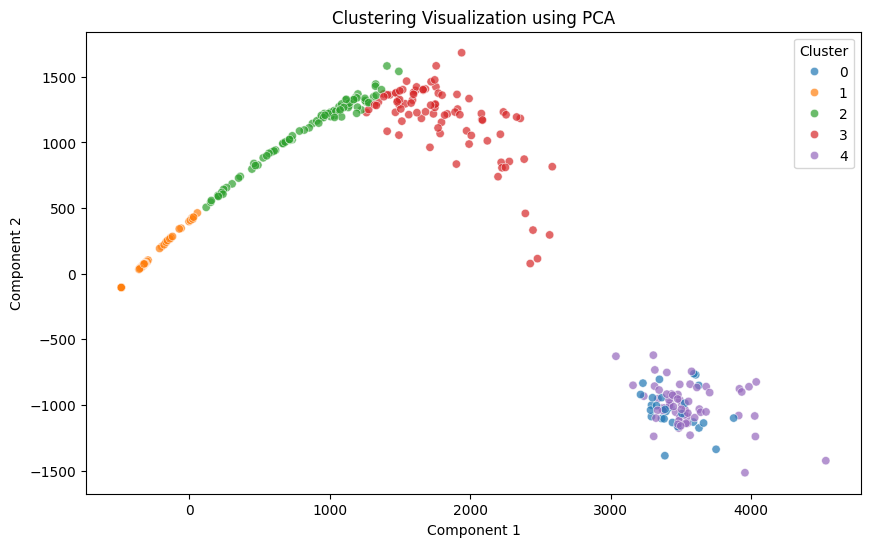

In [37]:
# best kmeans was orb
# Apply PCA
pca_features = apply_pca(orb_features, n_components=2)
plot_clusters(pca_features, kmeans_labels_orb, method="PCA")

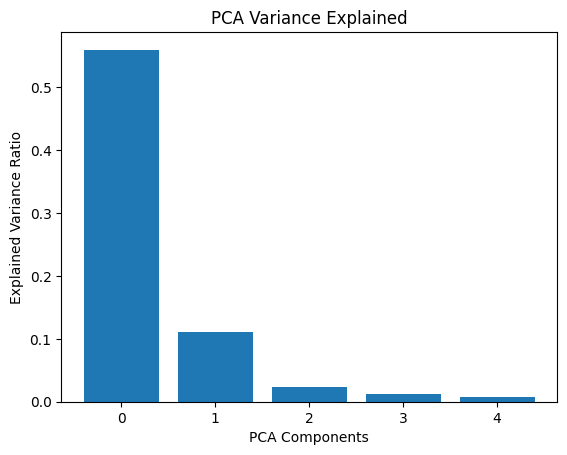

In [38]:
pca = PCA(n_components=5)
fit_trans_features = pca.fit_transform(orb_features)

# Plot explained variance
plt.bar(range(5), pca.explained_variance_ratio_)
plt.xlabel("PCA Components")
plt.ylabel("Explained Variance Ratio")
plt.title("PCA Variance Explained")
plt.show()

# What it means

- Most of the information in your dataset is captured by the first 2 components.

- Higher-order components `contribute very little`, meaning that reducing the data to 2 dimensions (PC1 & PC2) is likely sufficient for visualization.

- for feature reduction, keeping only the first 2-3 components might be enough without losing much information.

# Visualize using PC1 and PC2

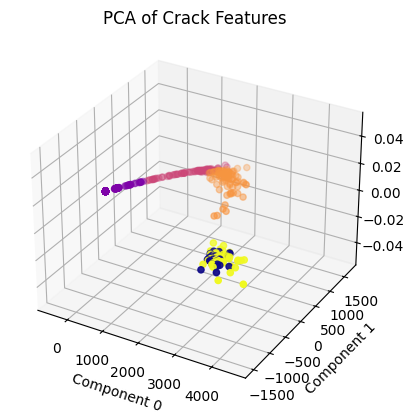

In [39]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.scatter(fit_trans_features[:, 0], fit_trans_features[:, 1], c=kmeans_labels_orb, cmap="plasma")
ax.set_xlabel("Component 0")
ax.set_ylabel("Component 1")
plt.title("PCA of Crack Features")
plt.show()

# Explanation
Each dot is an image from your the cracks dataset.

PCA (Principal Component Analysis) reduces high-dimensional ORB features (e.g., 1000-dim) down to 2D for visualization.

The colors represent clusters assigned by KMeans on the original ORB features (not the PCA).

## PC1 (Component 1) Represents the Primary Variation
PC1 is responsible for `the biggest differences` in your dataset.

The `points along the x-axis` (Component 1) are well spread, meaning `PC1 separates your data significantly`.

The clusters seem well-differentiated along PC1, indicating that the primary factor distinguishing these images is captured by this component.x

## PC2 (Component 2) Represents a Secondary Variation
The y-axis (Component 2) adds another layer of differentiation.

Clusters `are distributed non-linearly`, suggesting that PC2 might capture a more complex, but less dominant, structure in the images.

PC2 does not separate clusters as strongly as PC1, meaning that `whatever PC2 represents is less important in distinguishing images than PC1`.

## How This Affects Your Clustering
The separation of clusters along PC1 shows that the dataset has a dominant feature that effectively groups images.

The `curved pattern` suggests `a possible non-linear relationship in the data`, meaning that `PCA may not be fully capturing all variations`—you might need a non-linear dimensionality reduction method like t-SNE or UMAP for a different view.

### Cluster 0 & 4 (blue and light purple):

- Slight overlap with cluster 3 but generally form tight, defined clouds.

- Likely capturing similar textures with some subtle variance — could represent a different crack intensity or edge structure.

### Cluster 2 (green) & Cluster 1 (orange):

Form `a continuous arc` toward the left side of the plot.

Shows a gradient of features, possibly images with increasing complexity, like spreading cracks or mixed features (e.g., crack + background noise).

The curve implies that PCA captured a nonlinear transition in ORB space, and KMeans is segmenting this arc into parts.

# Examine what is changing

## 1. PC1: along the X-Axis? for PC1
- Identify sample images at the extreme left and extreme right of the PCA plot.

### Compare them visually:

1. Are the cracks getting bigger/smaller?

2. Is the intensity (brightness/contrast) increasing or decreasing?

3. Are the cracks wider/thinner?

> If PC1 mainly affects crack size, then PC1 might represent "crack severity".

## 2. PC2: What’s Changing Along the Y-Axis?

- Identify sample images at the top and bottom of the PCA plot.

### Compare them:

1. Do images at the top have more texture variations?

2. Are the cracks darker/lighter?

3. Is there more noise, dirt, or distortion?

> If PC2 mainly affects texture or noise, then PC2 might represent "surface texture complexity".

In [40]:
# Select images for analysis
def plot_pca_extreme_images(images, pca_features, filenames):
    """
    Display images from the extreme ends of PC1 and PC2 to analyze what they represent.
    """
    # Find extreme points in PC1 and PC2
    min_pc1_index = np.argmin(pca_features[:, 0])  # Extreme left (low PC1)
    max_pc1_index = np.argmax(pca_features[:, 0])  # Extreme right (high PC1)
    min_pc2_index = np.argmin(pca_features[:, 1])  # Bottom (low PC2)
    max_pc2_index = np.argmax(pca_features[:, 1])  # Top (high PC2)

    indices = [min_pc1_index, max_pc1_index, min_pc2_index, max_pc2_index]
    titles = ["Min PC1 (Left)", "Max PC1 (Right)", "Min PC2 (Bottom)", "Max PC2 (Top)"]

    plt.figure(figsize=(12, 6))

    for i, idx in enumerate(indices):
        plt.subplot(1, 4, i + 1)
        plt.imshow(images[idx].squeeze(), cmap="plasma")
        plt.title(f"{titles[i]}") # \n{filenames[idx]}
        plt.axis("off")

    plt.tight_layout()
    plt.show()

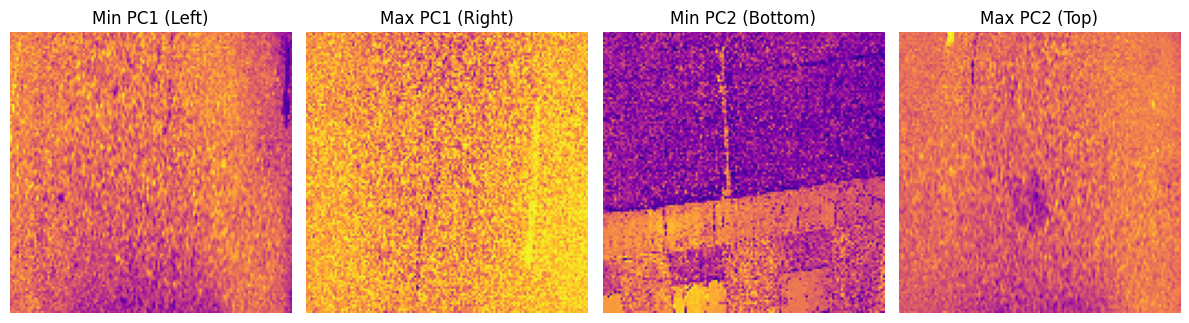

In [41]:
plot_pca_extreme_images(test_images, pca_features, test_filenames)

# PC1 Interpretation (X-Axis)
## Min PC1 (Left) Image:
- Slightly blurry or soft appearance.

- Texture is fairly uniform.

- Cracks are faint or thin—harder to detect.

- Illumination is low, less contrast overall.

## Max PC1 (Right) Image:
- Bright surface with clearly visible linear cracks.

- Strong contrast between crack lines and background.

- Surface details are much more pronounced.

- More complex and wider crack structures.

## Conclusion PC1
🤔 PC1 likely represents `crack severity` or `visual prominence of cracks`.

- **Low PC1** = Subtle or faint cracks, smoother texture, less detail.

- **High PC1** = Sharp, wide, and distinct crack patterns with stronger visual contrast.

# PC2 Interpretation (Y-Axis)
## Min PC2 (Bottom) Image:
- Significant blocky artifacts or structured patterns, possibly due to image tiling or compression.

- Strong vertical crack, but overall surface is less clear.

- Illumination appears uneven.

- Texture looks noisy or artificially segmented.

## Max PC2 (Top) Image:
- Uniform illumination.

- Fine-grained texture across the surface.

- Cracks are subtly present, but not dominant.

- Surface seems to be naturally rough or varied.

## Conclusion PC2
🤔 PC2 likely captures `surface texture consistency` and `spatial noise patterns`.

- **Low PC2** = Noisier, more artificial or segmented texture—possibly shadows, occlusions, or noise.

- **High PC2** = Consistent, detailed textures—may reflect natural road grain or low-level variations.

# Simplified Insight:
> PC1 helps discriminate based on crack presence and severity.
>
> PC2 captures variation in surface texture and noise patterns.

## Summary
|Principal Component|	What It Represents|Low Values Indicate|	High Values Indicate|
|:----|:----|:----|:----|
|PC1 (X-Axis)|Crack severity / visibility|Faint or no cracks|Strong, clear, wide cracks|
|PC2 (Y-Axis)|Texture complexity / surface smoothness|Uniform or noisy artifacts|Rich textures and natural surface detail


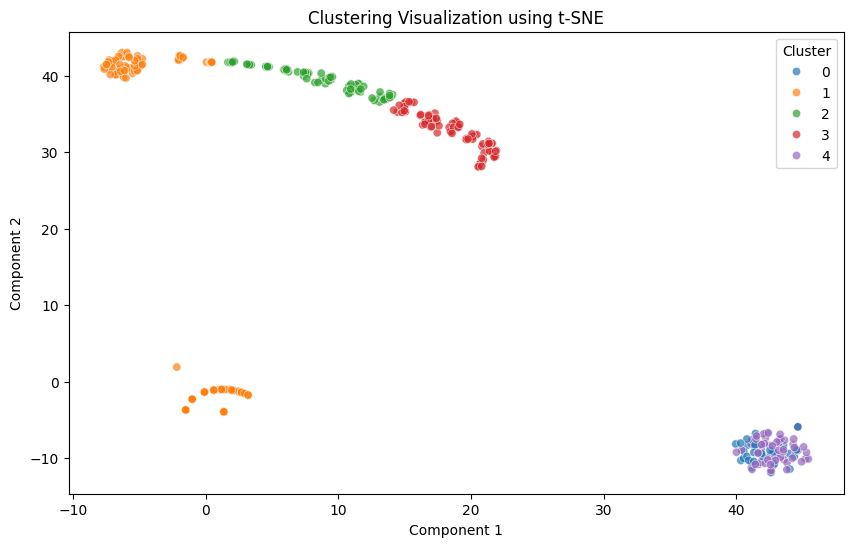

In [42]:
# Apply t-SNE
tsne_features = apply_tsne(orb_features, n_components=2, perplexity=30)
plot_clusters(tsne_features, kmeans_labels_orb, method="t-SNE")

# PCA vs t-SNE

|Aspect|PCA Visualization|t-SNE Visualization|
|:----|:----|:----|
|Algorithm|Linear dimensionality reduction|Non-linear manifold learning|
|Purpose|Maximize global variance|Preserve local structure (similar points stay close)|
|Component Meaning|Ordered by explained variance (Component 1 ≈ crack severity)|No interpretable axes—purely spatial separation|

## PCA
- Showed a smooth arc from Cluster 1 → 2 → 3, suggesting a gradual transition in image features (e.g., increasing crack visibility or complexity).
- Cluster 4 was tightly packed and well-separated.
- Good for visualizing overall structure and relationships.

## t-SNE Visualization Insights
- Cluster separation is more dramatic and localized.

&emsp;&emsp;&emsp;- `Clusters 3 & 4` (e.g., purple and blue) are tightly grouped, clearly distinct.

&emsp;&emsp;&emsp;- `Clusters 1 → 2 → 3` form a nonlinear progression, like PCA, but t-SNE bends the layout to maximize separation.

- `Cluster 1` appears split into two tight subclusters, suggesting potential internal variation within the same label (e.g., crack-free but different textures or lighting).

- `Cluster 0` overlaps slightly with 4 but maintains a coherent neighborhood.

## Key Observations
|Cluster|PCA View|t-SNE View|
|:----|:----|:----|
|0|Spread out; mixes slightly with 4|Tightly grouped, clearly near 4|
|1|Leftmost group; `uniform`|Shows two sub-clusters (`possible texture subtypes`)|
|2 → 3|Gradual arc of increasing crack detail|Still shows progression, but separation is clearer|
|4|Densely packed, far bottom-right|Clearly isolated and compact|

# Interpretation: t-SNE Enhances Cluster Boundaries
t-SNE better preserves local similarities, showing how individual ORB-based image patches relate.

It reveals finer structure, like subgroups within clusters or anomalies, which PCA flattens.

For visual cluster quality and boundary inspection, t-SNE gives a more intuitive look.

# Summary

|Goal|Use PCA|Use t-SNE|
|:----|:----|:----|
|Understand global trends|✅ Crack progression, gradients|❌ Less meaningful axes|
|Spot fine-grained groups|❌ Subtle|✅ Clear local clusters/subgroups|
|Performance (speed)|✅ Fast, scalable|❌ Slower, non-deterministic|
|Axis interpretation|✅ PC1 ≈ Crack Severity|❌ No direct meaning|




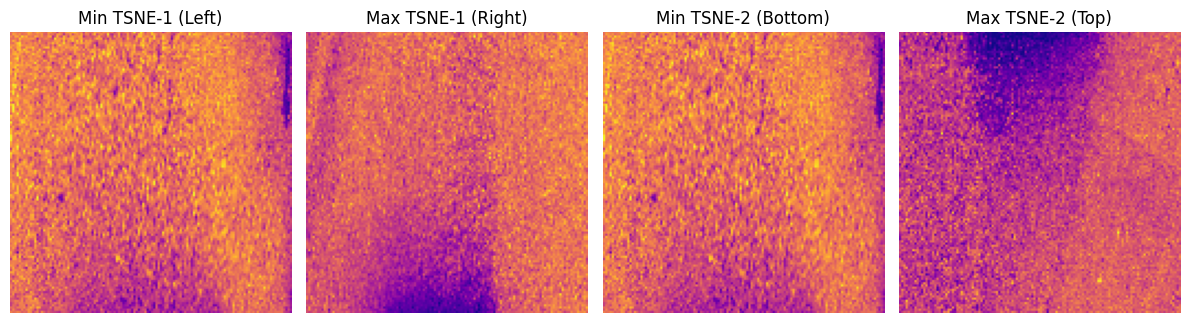

In [43]:
def plot_tsne_extreme_images(images, tsne_features, filenames):
    """
    Display images from the extreme ends of t-SNE components to analyze what they represent.

    Args:
        images (numpy array): The dataset images.
        tsne_features (numpy array): The t-SNE transformed feature matrix (2D).
        filenames (list): List of filenames corresponding to the images.
    """
    # Find extreme values for t-SNE components
    min_tsne1_index = np.argmin(tsne_features[:, 0])  # Extreme left (low TSNE-1)
    max_tsne1_index = np.argmax(tsne_features[:, 0])  # Extreme right (high TSNE-1)
    min_tsne2_index = np.argmin(tsne_features[:, 1])  # Bottom (low TSNE-2)
    max_tsne2_index = np.argmax(tsne_features[:, 1])  # Top (high TSNE-2)

    indices = [min_tsne1_index, max_tsne1_index, min_tsne2_index, max_tsne2_index]
    titles = ["Min TSNE-1 (Left)", "Max TSNE-1 (Right)", "Min TSNE-2 (Bottom)", "Max TSNE-2 (Top)"]

    plt.figure(figsize=(12, 6))

    for i, idx in enumerate(indices):
        plt.subplot(1, 4, i + 1)
        plt.imshow(images[idx].squeeze(), cmap="plasma")
        plt.title(f"{titles[i]}")# \n{filenames[idx]}
        plt.axis("off")

    plt.tight_layout()
    plt.show()

plot_tsne_extreme_images(test_images, orb_features, test_filenames)

# What This Means
- There is no clear distincton in the images

- The lack of clearly defined distinction tracks with the initial comparison between Kmeans and t-SNE

**Kmeans** is the better clustering technique

# Task 4: Contrastive Learning for Representation Learning

1. Implement SimCLR or another contrastive learning approach to learn visual
representations.
2. Train the model using contrastive loss and visualize the learned representations using tSNE.
3. Evaluate the learned representations by training a simple classifier on top of them.
## Deliverables:
* Code for SimCLR implementation
* t-SNE visualization of learned representations
* Comparison of classifier accuracy with vs. without contrastive learning


# 1. Implement SimCLR (Contrastive Learning)
SimCLR works like this

1. Take an image, apply two random augmentations, and treat them as a positive pair.

2. All other images in the batch are considered negatives.

3. Use a contrastive loss (NT-Xent) to bring positives closer and push negatives apart in embedding space.

## Core Components Needed
1. Data Augmentation Pipeline (Random crops, flips, color jitter, etc.)

2. Encoder Network (e.g., ResNet18 or custom CNN)

3. Projection Head (MLP that maps embeddings to a smaller latent space)

4. Contrastive Loss Function (NT-Xent)

# 2. Train Using Contrastive Loss
Train SimCLR to learn representations that group similar image patches together in embedding space, `without using any labels`.

# 3. Visualize with t-SNE
After training, extract the learned embeddings.

1. Use t-SNE to reduce them to 2D.

2. Visualize clusters.

# 4. Evaluate with a Classifier
Train a simple classifier (e.g., logistic regression or shallow MLP) on top of:

- SimCLR embeddings

- Raw features (e.g., HOG or CNN features without SimCLR)

Compare accuracies and show how contrastive learning improves representation quality.

## Simplified

```bash
                Input Image
                      │
           ┌──────────▼──────────┐
           │ Augmentation 1      │
           │ Augmentation 2      │
           └──────────┬──────────┘
                      ▼
             Shared Encoder (CNN)
                      ▼
              Projection Head (MLP)
                      ▼
               Contrastive Loss
                      │
                  Backprop

```

In [44]:
from tensorflow.keras import layers, models

In [45]:
def simclr_augment(image):
  """
  provides random augmentations for SimCLR

  args:
    image(numpy array): image to be augmented
  returns:
    image(numpy array)
  """
  image = tf.image.random_brightness(image, 0.2)
  image = tf.image.random_contrast(image, 0.2, 1.8)
  image = tf.image.random_flip_left_right(image)
  image = tf.image.random_crop(image, size=(112, 112, 1))  # Assume grayscale
  image = tf.image.resize(image, (128, 128))  # Resize back
  return image

def simclr_dataset(keras_path, batch_size=64):
  """
  loads the simclr dataset

  args:
    keras_path(str): path to the dataset
    batch_size(int): batch size
  returns:
    ds(tensorflow dataset)
  """
  ds = tf.data.experimental.load(keras_path)
  ds = ds.shuffle(1000).map(lambda img, lbl: img)
  ds = ds.map(lambda img: (simclr_augment(img), simclr_augment(img)))
  return ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [46]:
# build the model
def build_encoder():
  """
  creates an encoder model for SimCLR
  returns:
    encoder(tensorflow model)
  """
  inputs = tf.keras.Input(shape=(128, 128, 1))
  x = layers.Conv2D(32, 3, activation='relu')(inputs)
  x = layers.MaxPooling2D()(x)
  x = layers.Conv2D(64, 3, activation='relu')(x)
  x = layers.GlobalAveragePooling2D()(x)
  return tf.keras.Model(inputs, x)

def projection_head():
  """
  creates a projection head for SimCLR
  returns:
    head(tensorflow model)
  """
  return models.Sequential([
      layers.Dense(128, activation='relu'),
      layers.Dense(64)  # Contrastive space
  ])

In [47]:
# train with NT-Xent loss
def cosine_similarity(a, b):
  """
  Computes the cosine similarity between two sets of vectors.

  args:
    a(numpy array): first set of vectors
    b(numpy array): second set of vectors
  returns:
    similarity(numpy array)
  """
  a = tf.math.l2_normalize(a, axis=1)
  b = tf.math.l2_normalize(b, axis=1)
  return tf.matmul(a, b, transpose_b=True)

def nt_xent_loss(z1, z2, temperature=0.5):
  """
  Computes the Normalized Temperature-scaled Cross Entropy Loss.

  This loss function is commonly used in self-supervised learning,
  particularly for contrastive learning tasks. It encourages similar
  representations for augmented views of the same image and dissimilar
  representations for augmented views of different images.

  Args:
    z1: A tensor representing the embeddings of the first set of augmented images.
    z2: A tensor representing the embeddings of the second set of augmented images.
    temperature: A scalar value controlling the scaling of the cosine similarity.

  Returns:
    A scalar value representing the loss.
  """
  z = tf.concat([z1, z2], axis=0)
  sim = cosine_similarity(z, z) / temperature

  batch_size = tf.shape(z1)[0]
  labels = tf.range(batch_size)
  labels = tf.concat([labels, labels], axis=0)

  loss = tf.keras.losses.sparse_categorical_crossentropy(labels, sim, from_logits=True)
  return tf.reduce_mean(loss)

In [48]:
encoder = build_encoder()
proj_head = projection_head()

optimizer = tf.keras.optimizers.Adam()

for (img1, img2) in simclr_dataset("train_road_cracks.keras"):
    with tf.GradientTape() as tape:
        h1 = encoder(img1, training=True)
        h2 = encoder(img2, training=True)
        z1 = proj_head(h1)
        z2 = proj_head(h2)
        loss = nt_xent_loss(z1, z2)

    grads = tape.gradient(loss, encoder.trainable_variables + proj_head.trainable_variables)
    optimizer.apply_gradients(zip(grads, encoder.trainable_variables + proj_head.trainable_variables))

# Step 3

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


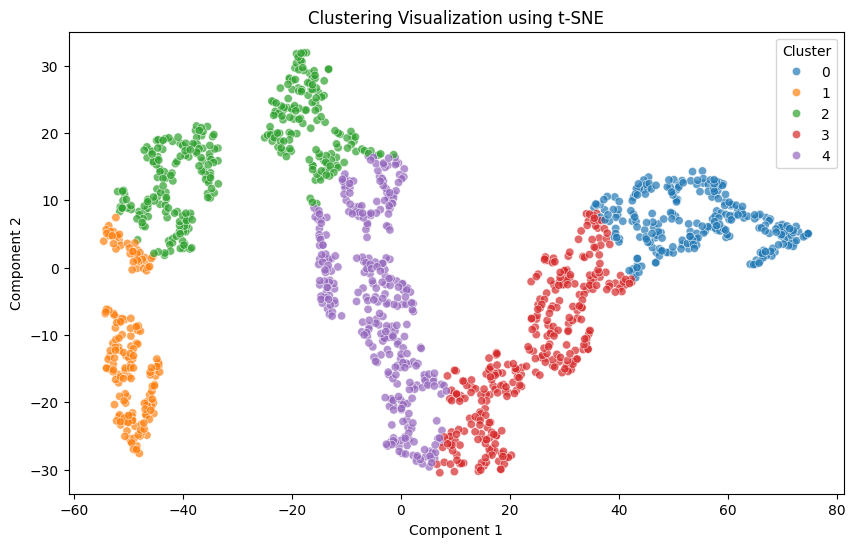

In [50]:
embeddings = encoder.predict(test_images)
tsne_embeddings = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(embeddings)

# Step 3: Cluster the embeddings (e.g., using K-Means)
kmeans = KMeans(n_clusters=5, random_state=42)
cluster_labels_embedding = kmeans.fit_predict(embeddings)

# Step 4: Plot clusters
plot_clusters(tsne_embeddings, cluster_labels_embedding, method="t-SNE")

# Task 5: Evaluation and Comparative Analysis

1. Compare the performance of **clustering-based vs. contrastive learning-based**
representations.
2. Analyze which method is more effective for image categorization and why.
3. Provide a **3-4 paragraph report** summarizing your findings, including strengths and
limitations of each approach (do this on the Jupyter notebook). The report should include
**methodology**, **key observations**, and **performance comparisons**.

## Deliverables:
* Comparative analysis (tables/graphs)
* Report discussing insights and observations

In [ ]:
"https://colab.research.google.com/drive/1mULTeG3dH16pWBzTiLbXEk7xueTcPito?usp=sharing" ==  "https://colab.research.google.com/drive/1mULTeG3dH16pWBzTiLbXEk7xueTcPito?usp=sharing"

# Bonus Task

1. Explore a **GAN-based unsupervised learning approach** (e.g., DeepCluster, SelfGAN)
for feature learning.
2. Compare its performance with SimCLR.

## Deliverables:
* Code implementation
* Brief analysis of results